In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
# from torchtext.vocab import vocab as torch_vocab

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from datasets import load_dataset

In [2]:
from pointer_gen.model import PGen
from pointer_gen.utils import get_counters, SummDataset, PointerDataPoint, SOS, EOS, PAD, OOV

In [3]:
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0")


specials = [SOS, EOS, PAD, OOV]


train_df = dataset['train']
val_df = dataset['validation']
test_df = dataset['test']

No config specified, defaulting to: gazeta/default
Found cached dataset gazeta (/home/goncharovglebig/.cache/huggingface/datasets/IlyaGusev___gazeta/default/2.0.0/c329f0fc1c22ab6e43e0045ee659d0d43c647492baa2a6ab3a5ea7dac98cd552)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create vocab
# src_counts = get_counters(train_df['text'], train_df['summary'])

In [5]:
# vocab = torch_vocab(src_counts, min_freq=70, specials=specials)
# vocab.set_default_index(vocab[OOV])
# vocab = vocab
# len(vocab)

In [6]:
# torch.save(vocab, 'gazeta_voc.pth')
vocab = torch.load('gazeta_voc.pth')
len(vocab)

43663

In [7]:
train_dataset = SummDataset(dataset['train']['text'], dataset['train']['summary'])
val_dataset = SummDataset(dataset['validation']['text'], dataset['validation']['summary'])

  0%|          | 0/60964 [00:00<?, ?it/s]

  0%|          | 0/6369 [00:00<?, ?it/s]

In [8]:
def collate_batch(batch):
    """
    Collects batch for model
    Returns:
        enc_input_padded - padded art_idxs tensor
        enc_input_ext_padded - padded art_exq_idxs tensor
        enc_padding_mask - pad mask for enc_input_padded
        extra_zeros - zeros for extented vocab
        dec_input_padded - padded abs_idxs tensor
        target_padded - padded abs_idxs extra tensor
        target_padding_mask - pad mask for target_padded
        target_lens - lens of decoder input
        
    """

    enc_list, enc_ext_list, dec_inp_list, target_list, oovs_len_list, target_lens_list, oovs = [], [], [], [], [], [], []
    batch_size = len(batch)
    for article, abstract in batch:
        data_point = PointerDataPoint(article, abstract, vocab)
        
        enc_input = torch.tensor(np.array(data_point.art_idxs))
        enc_input_ext = torch.tensor(np.array(data_point.art_ext_idxs))
        dec_input = torch.tensor(np.array(data_point.abs_idxs))
        target = torch.tensor(np.array(data_point.abs_ext_idxs))
        
        oovs.append(data_point.art_oovs)
        oovs_len_list.append(len(data_point.art_oovs))
        enc_list.append(enc_input)
        dec_inp_list.append(dec_input)
        enc_ext_list.append(enc_input_ext)
        target_list.append(target)
        target_lens_list.append(len(target))
        

    
    enc_input_padded = pad_sequence(enc_list, padding_value=vocab[PAD]).T
    enc_input_ext_padded = pad_sequence(enc_ext_list, padding_value=vocab[PAD]).T
    target_padded = pad_sequence(target_list, padding_value=vocab[PAD]).T
    dec_inp_padded = pad_sequence(dec_inp_list, padding_value=vocab[PAD]).T
    
    enc_padding_mask = enc_input_padded.ne(vocab[PAD]).long()
    target_padding_mask = target_padded.ne(vocab[PAD]).long()
    
    target_lens = torch.tensor(target_lens_list)
    
    max_oovs = max(oovs_len_list)
    extra_zeros = None
    if max_oovs > 0:
        extra_zeros = torch.zeros((batch_size, max_oovs), requires_grad=True)

    return (enc_input_padded.to(device), enc_input_ext_padded.to(device),
            enc_padding_mask.to(device), extra_zeros.to(device),
            dec_inp_padded.to(device), target_padded.to(device),
            target_padding_mask.to(device), target_lens.to(device),
            oovs
           )

In [10]:
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          collate_fn=collate_batch)
val_loader = DataLoader(val_dataset,
                          batch_size=32,
                          collate_fn=collate_batch)

In [16]:
# Training part
model = PGen(
    vocab_size=len(vocab),
    emb_dim=128, 
    hid_dim=256,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
min_loss = 99999
model.to(device)

params = list(model.parameters())
optimizer = torch.optim.Adagrad(params, lr=0.15, initial_accumulator_value=0.1)


epoch_num = 35
train_loss_list, val_loss_list = [], []

for ep in tqdm(range(epoch_num)):
    for train_batch in tqdm(train_loader):
        src, src_ext, src_mask, extra_zeros, dec_inp, trg, trg_mask, target_lens, _ = train_batch

        encoder_outputs, encoder_feature, s_t = model.encoder(src)
        step_losses = []
        batch_size = src.shape[0]
        max_dec_len = dec_inp.shape[1]
        
        
        # For first input
        c_t = torch.zeros((batch_size, 2 * s_t[0].shape[-1]), requires_grad=True).to(device)
        coverage = torch.zeros((src.shape), requires_grad=True).to(device)
        y_t = dec_inp[:, 0]
        
        for di in range(1, max_dec_len):
            final_dist, s_t,  c_t, attn_dist, p_gen, next_coverage = model.decoder(y_t,
                                                                                   s_t,
                                                                                   encoder_outputs,
                                                                                   encoder_feature,
                                                                                   src_mask,
                                                                                   c_t,
                                                                                   extra_zeros,
                                                                                   src_ext,
                                                                                   coverage,
                                                                                  )
            target = trg[:, di]
            gold_probs = torch.gather(final_dist, 1, target.unsqueeze(1)).squeeze()
            step_loss = -torch.log(gold_probs)

            step_coverage_loss = torch.sum(torch.min(attn_dist, coverage), 1)
            step_loss = step_loss + 0.1 * step_coverage_loss
            coverage = next_coverage

            step_mask = trg_mask[:, di]
            step_loss = step_loss * step_mask
            step_losses.append(step_loss)
            
            # Next token
            y_t = dec_inp[:, di]  # Teacher forcing
            
        sum_losses = torch.sum(torch.stack(step_losses, 1), 1)
        batch_avg_loss = sum_losses / target_lens
        loss = torch.mean(batch_avg_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.detach().item()
        train_loss_list.append(train_loss)


    #Validation loop
    with torch.no_grad():
        val_batch_loss = []
        for val_batch in tqdm(val_loader):
            src, src_ext, src_mask, extra_zeros, dec_inp, trg, trg_mask, target_lens, _ = val_batch
            encoder_outputs, encoder_feature, s_t = model.encoder(src)
            step_losses = []
            batch_size = src.shape[0]
            max_dec_len = dec_inp.shape[1]
            
            # For first input
            c_t = torch.zeros((batch_size, 2 * s_t[0].shape[-1]), requires_grad=True).to(device)
            coverage = torch.zeros((src.shape), requires_grad=True).to(device)
            y_t = dec_inp[:, 0]
            for di in range(1, max_dec_len):
                final_dist, s_t,  c_t, attn_dist, p_gen, next_coverage = model.decoder(y_t,
                                                                                       s_t,
                                                                                       encoder_outputs,
                                                                                       encoder_feature,
                                                                                       src_mask,
                                                                                       c_t,
                                                                                       extra_zeros,
                                                                                       src_ext,
                                                                                       coverage,
                                                                                      )
                target = trg[:, di]
                gold_probs = torch.gather(final_dist, 1, target.unsqueeze(1)).squeeze()
                step_loss = -torch.log(gold_probs)

                step_coverage_loss = torch.sum(torch.min(attn_dist, coverage), 1)
                step_loss = step_loss + 0.1 * step_coverage_loss
                coverage = next_coverage

                step_mask = trg_mask[:, di]
                step_loss = step_loss * step_mask
                step_losses.append(step_loss)
                
                y_t = dec_inp[:, di]  # Teacher forcing

            sum_losses = torch.sum(torch.stack(step_losses, 1), 1)
            batch_avg_loss = sum_losses / target_lens
            loss = torch.mean(batch_avg_loss).item()
            val_batch_loss.append(loss)
    val_epoch_loss = np.mean(val_batch_loss)
    val_loss_list.append(val_epoch_loss)
    if val_epoch_loss < min_loss:
        min_loss = val_epoch_loss
        print('Saving best model')
        torch.save(model, f'pointer_gazeta_v2.pth')    
    print(f'For epoch #{ep} train loss {np.mean(train_loss_list[-250_000:])}, val loss {np.mean(val_loss_list[-10_000:])}')

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

Saving best model
For epoch #3 train loss 5.491782564681574, val loss 5.210906625390052


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saving best model
For epoch #5 train loss 5.272197761686584, val loss 5.065595366557439


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

Saving best model
For epoch #6 train loss 5.186330221954126, val loss 5.008446770054953


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

Saving best model
For epoch #10 train loss 4.925017718730691, val loss 4.839208656007593


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

Saving best model
For epoch #11 train loss 4.8728252471473175, val loss 4.805439447065194


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saving best model
For epoch #17 train loss 4.620321273977445, val loss 4.66490825480885


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

For epoch #22 train loss 4.45887281318298, val loss 4.60150697350502


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

For epoch #25 train loss 4.374919862976777, val loss 4.578384827879758


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/200 [00:00<?, ?it/s]

For epoch #27 train loss 4.322730843420597, val loss 4.567718088413987


  0%|          | 0/1906 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

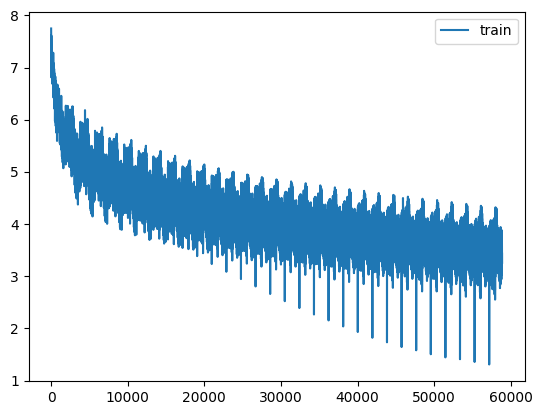

In [17]:
plt.plot(train_loss_list, label='train');
plt.legend();

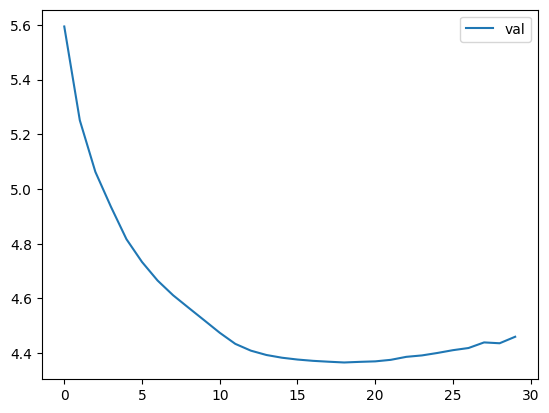

In [18]:
plt.plot(val_loss_list, label='val');
plt.legend();